# **Understanding natural language opinions**
## **with Topic Modeling and Summarization techniques.**

### Objetivos:

    Identificar las temáticas subyacentes al conjunto de opiniones.
    Facilitar la comprensión de las ideas y conceptos más sobresalientes en la Cognicion Colectiva de los usuarios.
    Automatizar este proceso que a un humano podría llevarle demasiado tiempo.    

## Preprocess

In [1]:
path_to_MyModule = '..'

import sys
sys.path.insert(0, path_to_MyModule) 

import pandas as pd
import matplotlib.pyplot as plt
from time import sleep

from MyModule.GeneralFunctions import *
from MyModule.SummarizationFunctions import *
from MyModule.SamplingFunctions import *
from MyModule.SemanticSimilarityFunctions import *
from MyModule.TopicModelingFunctinos import *

In [2]:
df = pd.read_excel('..\datos.xlsx')[['ID','texto','desafio']]

In [3]:
# Limpieza
df.drop_duplicates(subset='texto', inplace=True)

# Quitando texto de mas en columna "desafio"
df['desafio'] = df['desafio'].apply(lambda x: re.findall('[0-9]+', x)[0])

# A str
df['texto'] = df['texto'].astype(str)

## Select a desafio and n_clusters

In [150]:
data = df[df['desafio']=='16']['texto'].values

n_clusters = 6

## Select the most representative documents of each desafio's cluster

1. Obtener un vector semántico para cada documento (utilizando SentenceTransformers)
2. Clusterizar los documentos en base a sus vectores (utilizando KMeans o HDBScan)
3. Evaluar la similitud coseno de cada documento con el centroide de su cluster
4. Devolver los documentos ordenados de mayor a menos similitud

Así, los documentos son presentados en el orden en el que más capturan el significado y las ideas expresadas por la mayoria.

In [5]:
from MyModule.SummarizationFunctions import MostRepresentativeDocs

pp_object = Preprocess(lemma=False, stopwords=False)
mrd = MostRepresentativeDocs(cluster_algorithm='kmeans')

In [16]:
# all_res = {}
# for des in df['desafio'].unique():
#     this_data = df[df['desafio']==des]['texto'].values.tolist()
#     result = mrd.get_representatives(this_data, 5, pp_object)
#     all_res[des] = result

In [151]:
result = mrd.get_representatives(data, n_clusters=n_clusters, pp_object=pp_object)

In [152]:
mrd.get_average_silhouette_score()

0.067404

1: desconozco + control estatal + empresas + caba vs pais
5: relacion con los trabajadores

In [217]:
result[5]

[('EL transporte publico en todo el mundo es subsidiado. Creo que hay que regular que ese financiamiento favorezca a les que menos tienen y no que favorezca intereses de los grupos empresariales. Que ese subsidio permita que un trabajador pueda salir de sus barrios y llegar a horario a sus puestos de trabajo, viajando de manera digna.',
  0.8380857),
 ('Estoy parcialmente de acuerdo con esta frase ya que, por un lado, es necesario que el Ministerio de Transporte regule y controle los medios de transporte público, pero por otro, los subsidios son necesarios. Además, es plata del propio pueblo que hace que podamos acceder a un boleto más barato, de lo contrario es muy difícil para la gente que todos los días viaja a trabajar, para buscar trabajo o estudiar ya que representa una cantidad de dinero importante, sobre todo quienes trabajan o viven en el conurbano y viajan a o desde capital ya que el boleto es muy caro y hay quienes toman más de un transporte. ',
  0.8220376),
 ('Totalmente e

In [218]:
mrd.get_cluster_silhouette_score(5)

0.09217963

## Find clusters in cluster

In [122]:
only_text = [v[0] for v in result[1]]
result_cluster = mrd.get_representatives(only_text, n_clusters=4, pp_object=pp_object)
data = only_text.copy()

In [145]:
result_cluster[3]

[('Desde hace muchos años los planes sociales vienen siendo la herramienta que no solo da una ayuda económica a los beneficiarios, sino que se utilizan para realizar mejoras en los barrios populares (huertas, limpieza, obras pequeñas). En muchas organizaciones sociales estos planes son considerados trabajo (aunque falte mucho para que se consideren trabajo digno). La herramienta de los planes sociales es necesaria para momentos de crisis, pero desde hace muchos años es una política de estado clientelar para los gobiernos de turno. Los movimientos sociales independientes vienen hace años exigiendo que se mejoren las condiciones laborales de los programas.',
  0.80276155),
 ('Me parece una estupidez grande como una casa, la frase "está difícil conseguir trabajo por como está la economía" es una excusa para aquellos que realmente no quieren trabajar, en el tema de los planes sociales estoy de acuerdo que sean asignados para aquellos que tengan discapacidades, gente mayor, o que realmente 

## Word count plot

Plotear las palabras mas frecuentes para cada cluster

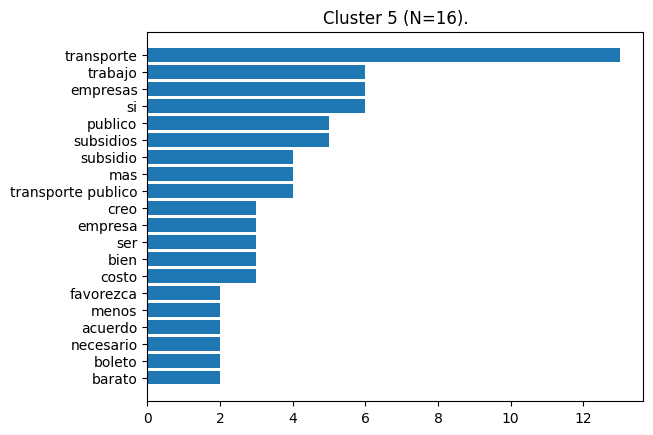

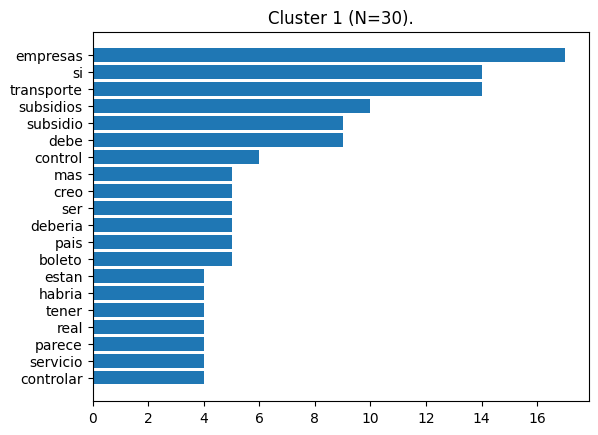

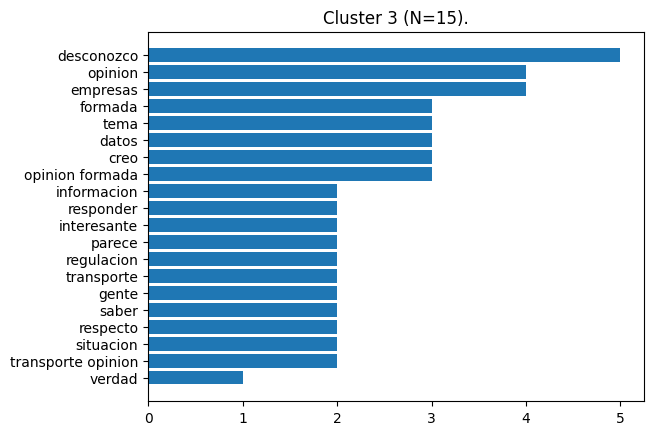

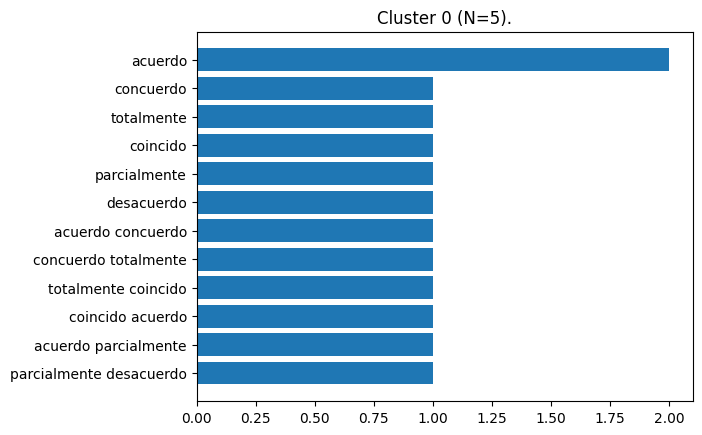

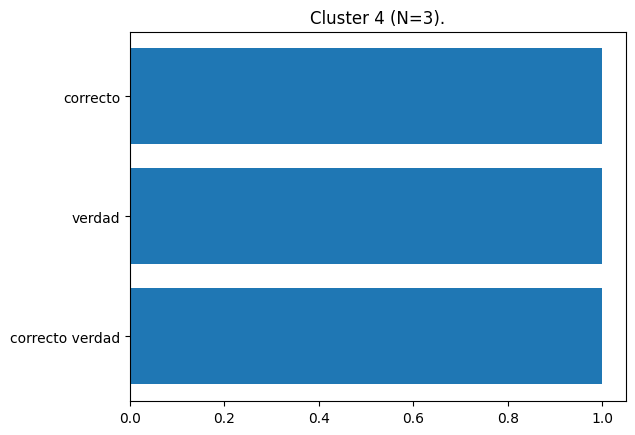

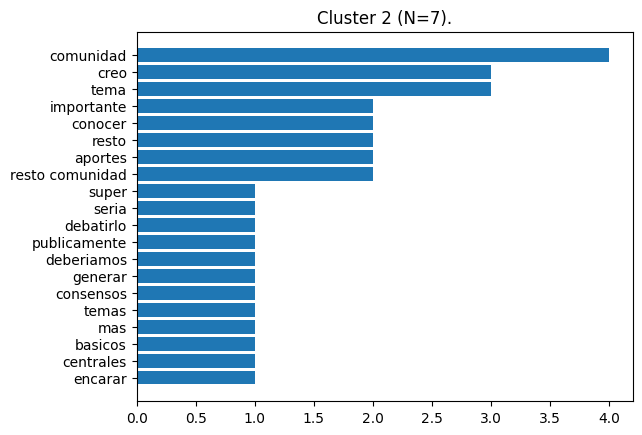

In [211]:
pp_object_transformers = Preprocess(lemma=False, stopwords=False, alphanumeric=False, join=False)
pp_object_word_count = Preprocess(lemma=False)

mrd.plot_word_counts(data, n_clusters=n_clusters, pp_object_transformers=pp_object_transformers, pp_object_word_count=pp_object_word_count)

## Finding optimum K
Eje X: numero de clusters

Eje Y: Sum of Squared Distance de cada punto con su centroide

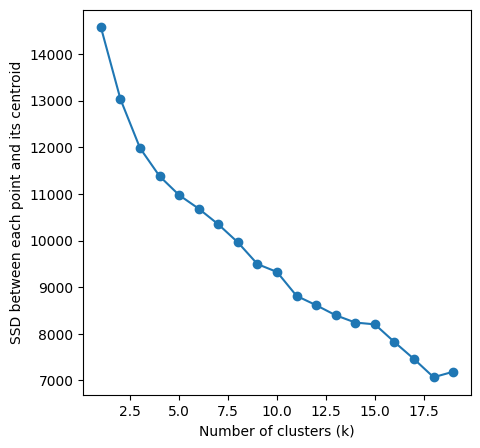

In [148]:
mrd.elbow_method(data, k_range=[1, 20], pp_object=pp_object)

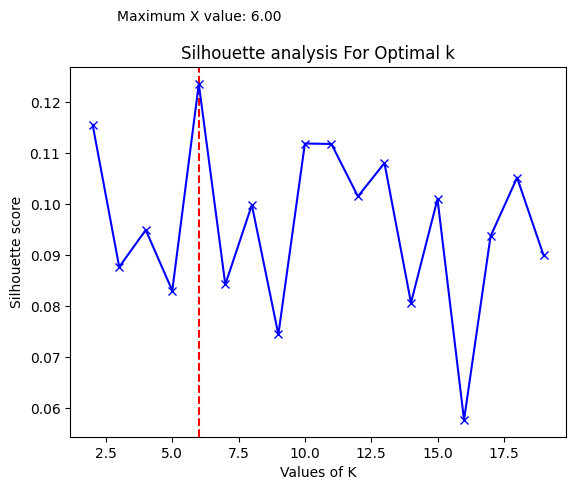

In [149]:
mrd.plot_elbow_silhouette_score(range_n_clusters=[2,20])

## Clusters: Size and Shape

ATENCION: 

debido a que primero se realiza una reduccion de dimensiones, el tamaño y la forma de cada cluster del gráfico puede ser distinto al encontrado en la realidad.

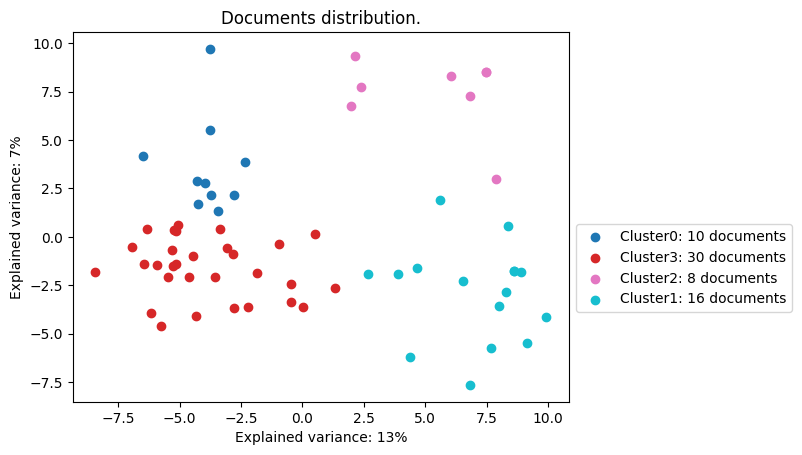

In [62]:
mrd.visualize_documents_kmeans(data, n_clusters=n_clusters, pp_object=pp_object)

# Combination: summarization for each topic's cluster

Apply T5 and BETO summarization to each cluster

In [32]:
# Models
beto = BETOSummary()
t5 = T5Summary()
embedding_model = MostRepresentativeDocs()

ckpt:
mrm8488/bert2bert_shared-spanish-finetuned-summarization


The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']


ckpt:
josmunpen/mt5-small-spanish-summarization


In [33]:
desafio = '17'
data = df.query(f'desafio == "{desafio}"')['texto'].values
pp_object = Preprocess(lemma=False, stopwords=False, alphanumeric=False, join=False)

In [34]:
labeled_docs = embedding_model.cluster_and_label_original_docs(data, 3, pp_object)

for key, values in labeled_docs.items():
    values = pp_object.preprocess(values)
    text = '.\n'.join(values)
    print(f'BERT, Cluster {key}:\n{beto.generate_summary(text)}\n\n')
    sleep(2)
    print(f'T5, Cluster {key}:\n{t5.generate_summary(text)}\n\n')

BERT, Cluster 1:
['La nota que se paga creo que inversion no es un problema que falta en ese caso', 'La reducción de tareas extracurriculares ya que esta re de moda baches eternos de 3 horas']




KeyboardInterrupt: 

# Sample representative docs

In [31]:
desafio = '17'

documents = df[df['desafio']==desafio]['texto'].values

pp_object = Preprocess(lemma=False, stopwords=False, alphanumeric=False, join=False)

sr = SampleRepresentatives()
res = sr.get_sample(documents, pp_object=pp_object, n_clusters=5)

In [32]:
print(f'Desafio: {desafio}')
for key, value in res.items():
    print(f'\nCluster: {key}\n')
    for v in value[:3]:
        print(v)

Desafio: 17

Cluster: 1

Menos tareas extracurriculares ya que tenemos mucha carga horaria de cursada
mantas en la biblioteca.
Mejores horarios de cursada (menos baches).

Cluster: 3

Horarios mas normales
Horarios más estructurados, que sean o en la mañana o en la tarde, que estén juntos, y que estén distribuidos de forma uniforme a lo largo de la semana. 
más horarios de combis.

Cluster: 0

Comida sin harina en el kiosco 
Mesa de ping pong, canchita de futbol tenis y mesa teqball (es la mesa tipo ping pong para jugar con pelota de futbol)
más comidas hechas como tartas, ensaladas, etc

Cluster: 2

Estaria bueno que la experiencia 2023 tuviese clases magatrales mas pequeñas, de todas maneras me encanto como se dicto esta materia
Más sillitas para sentarse en el campus, más espacios con sombra natural, horarios de la combi más puntuales (desde la estación victoria siempre algún retraso tiene y eso hace que lleguemos tarde a clases)
La cursada sea menor, es decir, entiendo que el nivel